In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import re
from collections import Counter
from matplotlib.lines import Line2D

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B

#### Races
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Independent)  

### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

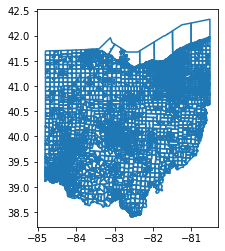

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
elections_2020_raw = pd.read_excel("./raw-from-source/SOS/statewideresultsbyprecinct.xlsx",sheet_name="Master")

In [8]:
def clean_oh_import(dataframe):
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col_name = dataframe.columns[index]
        col_name = col_name.replace("\n"," ")
        if "Unnamed" in col_name:
            corrected_col_names.append(corrected_col_names[index-1])
        else:
            corrected_col_names.append(col_name)
    dataframe.columns = corrected_col_names
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col = dataframe.columns[index]
        first_row = dataframe.iloc[0,index]
        if (index > 7):
            new_column_name = col + " " + first_row 
            corrected_col_names.append(new_column_name)
        else:
            corrected_col_names.append(first_row)
    dataframe.columns = corrected_col_names
    
    dataframe = dataframe.iloc[3:,]
    return dataframe

In [9]:
elections_2020 = clean_oh_import(elections_2020_raw)

In [10]:
filter_out_cols = [i for i in elections_2020.columns if ("Judge of the Court of Appeals - District" in i or "Member of the State Board of Education - District" in i or "WI" in i)]

In [11]:
elections_2020 = elections_2020[[i for i in elections_2020.columns if i not in filter_out_cols]]

In [12]:
#Map to the correct FIP
elections_2020["COUNTYFP"]=elections_2020["County Name"].map(oh_fips_dict).fillna(elections_2020["County Name"])

#Print out the FIPS to make sure they all are in the correct format
elections_2020["COUNTYFP"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '055', '057', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111', '113', '115', '117', '119', '121', '123', '125',
       '127', '129', '131', '133', '135', '137', '139', '141', '143',
       '145', '147', '149', '151', '153', '155', '157', '159', '161',
       '163', '165', '167', '169', '171', '173', '175'], dtype=object)

## Look into split precincts

In [13]:
def get_level_dist(column_name):
    if "Representative to Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
    else:
        raise ValueError
    return_val = re.findall("District \S{2}",column_name)    
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
    else:
        raise ValueError
    return level,dist

In [14]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [15]:
district_cols = [i for i in elections_2020.columns if "District" in i]
elections_2020_districts = elections_2020[['COUNTYFP','Precinct Name','Precinct Code']+district_cols]

In [16]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in elections_2020_districts.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["COUNTYFP"]+"-"+row["Precinct Code"]]=is_split
    precinct_mapping_dict[row["COUNTYFP"]+"-"+row["Precinct Code"]]=precinct_list


## Rename Columns

In [17]:
elections_2020.columns

keep_names = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','COUNTYFP']

In [18]:
def get_race(contest):
    if "Justice of the Supreme Court" in contest:
        level = "SSC"
        if "Kennedy" in contest or "O'Donnell" in contest:
            level = "SSCK"
        else:
            level = "SSCF"
    elif "President" in contest:
        level = "PRE"
    elif ("Representative to Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]
    else:
          raise ValueError
    return level

"Although elections for the Ohio Supreme Court are officially nonpartisan, they are preceded by a partisan primary."

In [19]:
def get_party(contest):
    if contest == "State Representative - District 30  Tom Roll":
        return "I"
    if "Justice of the Supreme Court Term" in contest:
        if "Sharon L. Kennedy" in contest:
            return "R"
        elif "John P. O'Donnell" in contest:
            return "D"
        elif "Jennifer Brunner" in contest:
            return "D"
        elif "Judi French" in contest:
            return "R"
        else:
            print(contest)
            raise ValueError
    return_val = re.findall("\(\S\)",contest)   
    if (len(return_val)!=0):
        party = return_val[0][1]
        return party
    else:
        print(contest)
        raise ValueError

In [20]:
def get_name(contest):
    contest = contest.upper()
    contest = contest.replace("'","")
    if ("(") in contest.split(" ")[-1]:
        second_to_last = contest.split(" ")[-2]
        #second_to_last = second_to_last.replace("'","")
        if second_to_last in ["JR","III"]:
            third_to_last = contest.split(" ")[-3]
            #third_to_last = third_to_last.replace("'","")
            return third_to_last[0:3]
        else:
            return second_to_last[0:3]
    else:
        return contest.split(" ")[-1][0:3] 

In [21]:
contest_name_change_dict = {
 'President and Vice President  Joseph R. Biden and Kamala D. Harris (D)':'G20PREDBID',
 'President and Vice President  Howie Hawkins and Angela Walker':'G20PREGHAW',
 'President and Vice President  Jo Jorgensen and Spike Cohen (L)':'G20PRELJOR',
 'President and Vice President  Donald J. Trump and Michael R. Pence (R)':'G20PRERTRU',
}

In [22]:
for contest in elections_2020.columns:
    if contest not in keep_names and "President" not in contest:
        contest_name_change_dict[contest] = "G"+get_race(contest)+get_party(contest)+get_name(contest)

In [23]:
elections_2020.rename(columns=contest_name_change_dict,inplace=True)

In [24]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.to_csv('./cand_dicts/oh_gen_20_sldu_prec.csv', sep=',')

In [25]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Ballots Counted',
 'Official Voter Turnout',
 'G20PREDBID',
 'G20PREGHAW',
 'G20PRELJOR',
 'G20PRERTRU',
 'GCON01RCHA',
 'GCON01LKAH',
 'GCON01DSCH',
 'GCON02DCAS',
 'GCON02RWEN',
 'GCON03DBEA',
 'GCON03RRIC',
 'GCON04DFRE',
 'GCON04RJOR',
 'GCON04LPER',
 'GCON05RLAT',
 'GCON05DRUB',
 'GCON06RJOH',
 'GCON06DROB',
 'GCON07RGIB',
 'GCON07LLAP',
 'GCON07DPOT',
 'GCON08RDAV',
 'GCON08DENO',
 'GCON09DKAP',
 'GCON09RWEB',
 'GCON10DTIM',
 'GCON10RTUR',
 'GCON11DFUD',
 'GCON11RGOR',
 'GCON12RBAL',
 'GCON12DSHE',
 'GCON12LSTE',
 'GCON13LFRI',
 'GCON13RHAG',
 'GCON13DRYA',
 'GCON14RJOY',
 'GCON14DMUE',
 'GCON15DNEW',
 'GCON15RSTI',
 'GCON16DGOD',
 'GCON16RGON',
 'GSU02RGAV',
 'GSU02DODO',
 'GSU04RLAN',
 'GSU04DWYE',
 'GSU06RANT',
 'GSU06DFOG',
 'GSU08RBLE',
 'GSU08DBRO',
 'GSU10DBAL',
 'GSU10RHAC',
 'GSU12RHUF',
 'GSU12DPOL',
 'GSU14RJOH',
 'GSU14DOTT',
 'GSU16RKUN',
 'GSU16DLET',
 'GSU18

### Filter Down to Relevant Columns

In [26]:
keeper_columns = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','COUNTYFP']
state_senate = [i for i in list(elections_2020.columns) if "GSU" in i]

In [27]:
elections_2020 = elections_2020[keeper_columns+state_senate]

### Compare Precinct Totals

In [28]:
elections_2020["UNIQUE_ID"] = elections_2020["COUNTYFP"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["UNIQUE_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

In [29]:
#Confirm unique IDs are unique
print(elections_2020["UNIQUE_ID"].value_counts(dropna=False))
print(vest_oh_20["UNIQUE_ID"].value_counts(dropna=False))

099-AMV    1
035-BVH    1
101-ABP    1
035-DBF    1
049-BKO    1
          ..
099-ASN    1
061-BIT    1
025-ABV    1
103-AAB    1
035-CYE    1
Name: UNIQUE_ID, Length: 8933, dtype: int64
099-AMV    1
141-AAQ    1
049-ACO    1
061-BKS    1
049-AQD    1
          ..
093-ALL    1
151-ALK    1
029-AEO    1
049-ALY    1
035-CYE    1
Name: UNIQUE_ID, Length: 8941, dtype: int64


In [30]:
elections_2020.columns

Index(['County Name', 'Precinct Name', 'Precinct Code', 'Region Name',
       'Media Market', 'Registered Voters', 'Ballots Counted',
       'Official Voter Turnout', 'COUNTYFP', 'GSU02RGAV', 'GSU02DODO',
       'GSU04RLAN', 'GSU04DWYE', 'GSU06RANT', 'GSU06DFOG', 'GSU08RBLE',
       'GSU08DBRO', 'GSU10DBAL', 'GSU10RHAC', 'GSU12RHUF', 'GSU12DPOL',
       'GSU14RJOH', 'GSU14DOTT', 'GSU16RKUN', 'GSU16DLET', 'GSU18RCIR',
       'GSU18DRAD', 'GSU20DJOH', 'GSU20RSCH', 'GSU22DHUN', 'GSU22RROM',
       'GSU24RDOL', 'GSU24DJAC', 'GSU26RREI', 'GSU26DSWA', 'GSU28RDOW',
       'GSU28DSYK', 'GSU30DFLE', 'GSU30RHOA', 'GSU32ROBR', 'GSU32DOBR',
       'UNIQUE_ID'],
      dtype='object')

In [31]:
attempt_one = pd.merge(vest_oh_20,elections_2020,how="outer",on="UNIQUE_ID",indicator=True)
print(attempt_one["_merge"].value_counts())


vest_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only = attempt_one[attempt_one["_merge"]=="right_only"]

#attempt_one[attempt_one["_merge"]=="left_only"].to_csv("./source.csv")
#attempt_one[attempt_one["_merge"]=="right_only"].to_csv("./vest.csv")

both          8933
left_only        8
right_only       0
Name: _merge, dtype: int64


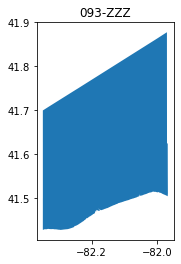

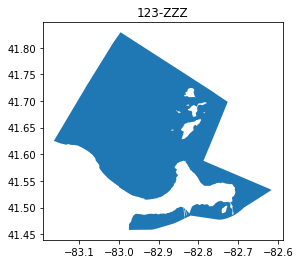

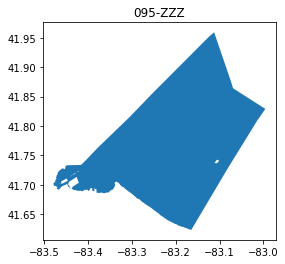

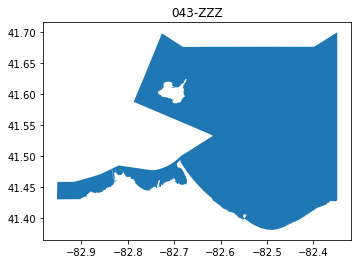

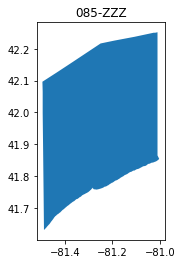

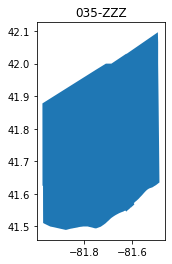

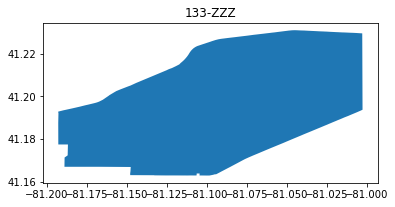

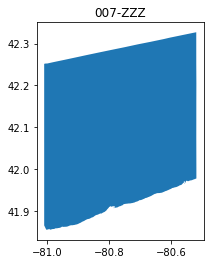

In [32]:
for index,row in vest_only.iterrows():
    ax = attempt_one.iloc[[index]].plot()
    ax.set_title(row["UNIQUE_ID"])

In [33]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID', 'County Name', 'Precinct Name', 'Precinct Code',
       'Region Name', 'Media Market', 'Registered Voters', 'Ballots Counted',
       'Official Voter Turnout', 'COUNTYFP', 'GSU02RGAV', 'GSU02DODO',
       'GSU04RLAN', 'GSU04DWYE', 'GSU06RANT', 'GSU06DFOG', 'GSU08RBLE',
       'GSU08DBRO', 'GSU10DBAL', 'GSU10RHAC', 'GSU12RHUF', 'GSU12DPOL',
       'GSU14RJOH', 'GSU14DOTT', 'GSU16RKUN', 'GSU16DLET', 'GSU18RCIR',
       'GSU18DRAD', 'GSU20DJOH', 'GSU20RSCH', 'GSU22DHUN', 'GSU22RROM',
       'GSU24RDOL', 'GSU24DJAC', 'GSU26RREI', 'GSU26DSWA', 'GSU28RDOW',
       'GSU28DSYK', 'GSU30DFLE', 'GSU30RHOA', 'GSU32ROBR', 'GSU32DOBR',
       '_merge'],
      dtype='object')

In [34]:
races = ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW']

#Confirm these are all zero-vote races
races_x =["UNIQUE_ID"]
races_y =["UNIQUE_ID"]

# for val in races:
#     races_x.append(val+"_x")
#     races_y.append(val+"_y")

print((vest_only[races]))


      G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW
814            0           0           0           0
982            0           0           0           0
2924           0           0           0           0
3674           0           0           0           0
4389           0           0           0           0
4565           0           0           0           0
5357           0           0           0           0
7951           0           0           0           0


## Clean up the unjoined results

In [35]:
attempt_one.drop(["_merge",'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW'],inplace=True,axis=1)

In [36]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'geometry', 'UNIQUE_ID', 'County Name', 'Precinct Name',
       'Precinct Code', 'Region Name', 'Media Market', 'Registered Voters',
       'Ballots Counted', 'Official Voter Turnout', 'COUNTYFP', 'GSU02RGAV',
       'GSU02DODO', 'GSU04RLAN', 'GSU04DWYE', 'GSU06RANT', 'GSU06DFOG',
       'GSU08RBLE', 'GSU08DBRO', 'GSU10DBAL', 'GSU10RHAC', 'GSU12RHUF',
       'GSU12DPOL', 'GSU14RJOH', 'GSU14DOTT', 'GSU16RKUN', 'GSU16DLET',
       'GSU18RCIR', 'GSU18DRAD', 'GSU20DJOH', 'GSU20RSCH', 'GSU22DHUN',
       'GSU22RROM', 'GSU24RDOL', 'GSU24DJAC', 'GSU26RREI', 'GSU26DSWA',
       'GSU28RDOW', 'GSU28DSYK', 'GSU30DFLE', 'GSU30RHOA', 'GSU32ROBR',
       'GSU32DOBR'],
      dtype='object')

In [37]:
final_race_list = ['GSU02RGAV', 'GSU02DODO',
'GSU04RLAN', 'GSU04DWYE', 'GSU06RANT', 'GSU06DFOG', 'GSU08RBLE',
'GSU08DBRO', 'GSU10DBAL', 'GSU10RHAC', 'GSU12RHUF', 'GSU12DPOL',
'GSU14RJOH', 'GSU14DOTT', 'GSU16RKUN', 'GSU16DLET', 'GSU18RCIR',
'GSU18DRAD', 'GSU20DJOH', 'GSU20RSCH', 'GSU22DHUN', 'GSU22RROM',
'GSU24RDOL', 'GSU24DJAC', 'GSU26RREI', 'GSU26DSWA', 'GSU28RDOW',
'GSU28DSYK', 'GSU30DFLE', 'GSU30RHOA', 'GSU32ROBR', 'GSU32DOBR']

In [38]:
for race in final_race_list:
    attempt_one[race] =attempt_one[race].fillna(0)
    attempt_one[race] =attempt_one[race].astype(int)

## Add in a SLDU_DIST column

Note: We know that for the SLU districts where there are election results, there are no splits, for others we don't know them

In [39]:
attempt_one["Tot_Votes"] = 0

for race in final_race_list:
    attempt_one["Tot_Votes"] += attempt_one[race]

In [40]:
attempt_one[attempt_one["Tot_Votes"]>0].shape

(4427, 50)

In [41]:
def contains_sll(dist_list):
    #print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        #print("Call on ", dist_tuple)
        if dist_tuple[0] == "SU":
            print("Found the SU")
            return dist_tuple[1]
        

In [42]:
check_list = {i:contains_sll(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU

Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU

Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU

Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU
Found the SU

In [43]:
len([i for i in check_list.keys() if check_list[i]!=None])

4427

In [44]:
attempt_one["SLDU_DIST"] = attempt_one["UNIQUE_ID"].map(check_list).fillna("n/a")

In [45]:
attempt_one["SLDU_DIST"].value_counts(dropna=False)

n/a    4514
30      358
14      327
26      310
16      294
32      280
02      276
18      274
20      273
04      270
12      268
24      266
10      260
22      250
28      249
08      239
06      233
Name: SLDU_DIST, dtype: int64

## Compare assignments against the original file

In [46]:
oh_st_sen_districts = gp.read_file("./raw-from-source/District_Shapefiles/oh_pl2020_sldu/oh_pl2020_sldu.shp")

In [47]:
included_sen_races = list(attempt_one["SLDU_DIST"].unique())
included_sen_races.remove('n/a')

In [48]:
print(included_sen_races)

['30', '26', '04', '10', '02', '20', '12', '32', '14', '22', '08', '18', '06', '24', '28', '16']


In [49]:
oh_st_sen_districts["SLDU_DIST"] = oh_st_sen_districts["SLDUST20"].str[1:3]

In [50]:
filtered_sen = oh_st_sen_districts[oh_st_sen_districts["SLDU_DIST"].isin(included_sen_races)]

In [51]:
filtered_results = attempt_one[attempt_one["SLDU_DIST"].isin(included_sen_races)]

In [52]:
filtered_results = filtered_results.dissolve("SLDU_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [53]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
    if (left_geoms.is_valid==False).any():
        raise ValueError
    elif(right_geoms.is_valid==False).any():
        raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 16 precincts for differences of greater than 0.1 km^2

1) For 06 difference in area is 1.0897430128482644
2) For 20 difference in area is 0.6985590172426828
3) For 26 difference in area is 2.667340561642888
4) For 14 difference in area is 2.0842928953398587
5) For 28 difference in area is 0.7223172542445856
6) For 12 difference in area is 1.0134087317187426
7) For 02 difference in area is 4.222473853987277
8) For 32 difference in area is 0.1398745818324628
9) For 18 difference in area is 14.572609383699616
10) For 08 difference in area is 0.38508087079972886
11) For 22 difference in area is 12.504824517776129
12) For 24 difference in area is 1.5495914342575614
13) For 16 difference in area is 5.8200545460131154

Scroll down to see plots of any differences

Of the 16 precincts:

0 precincts w/ a difference of 0 km^2
3 precincts w/ a difference between 0 and .1 km^2
2 precincts w/ a difference between .1 and .5 km^2
2 precincts w/ a difference between .5 and 1 km^2
3 precincts w

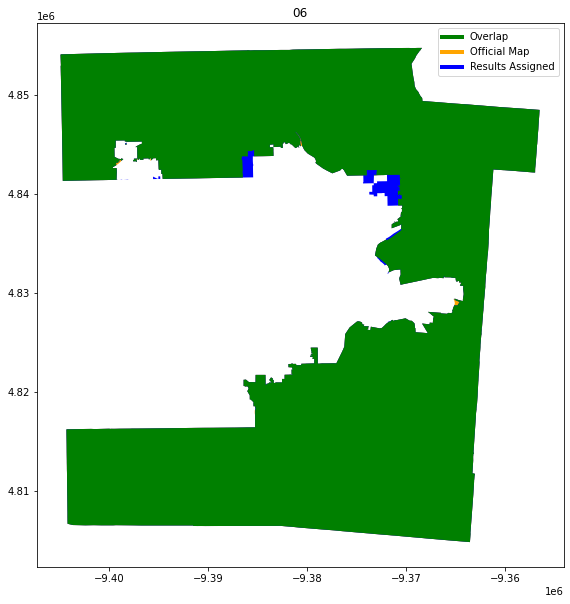

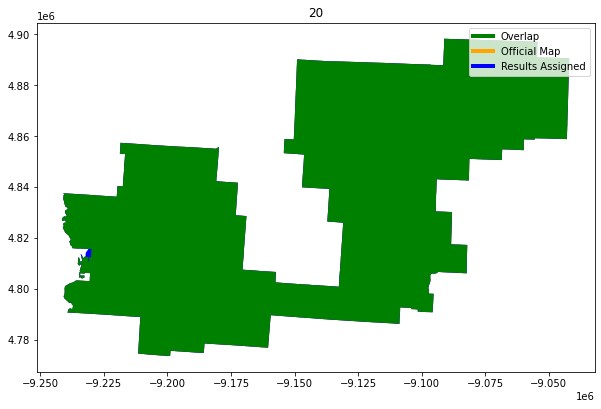

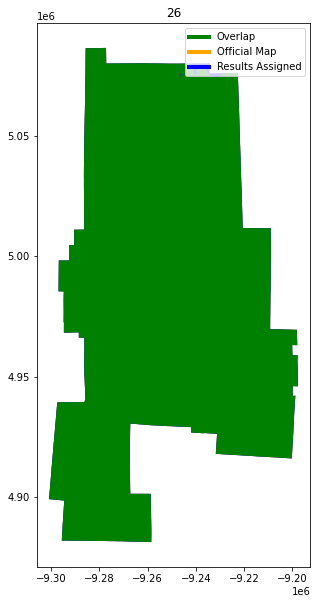

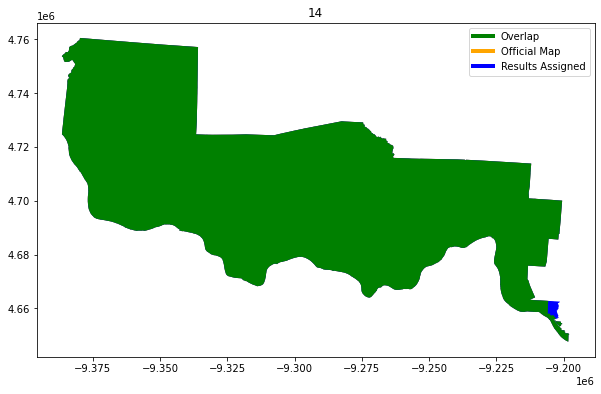

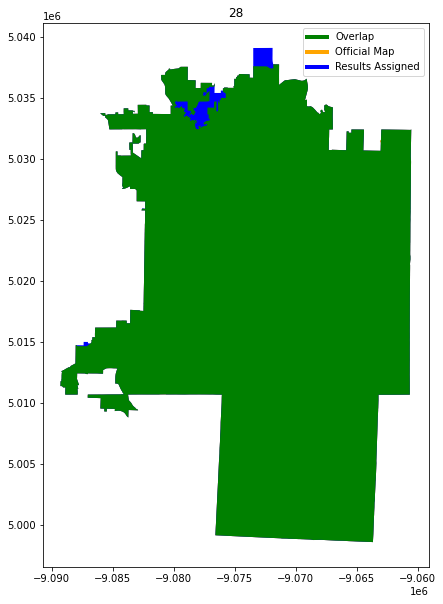

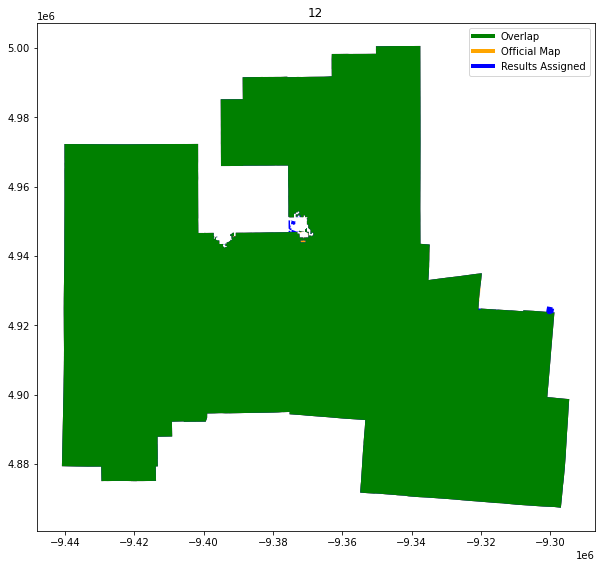

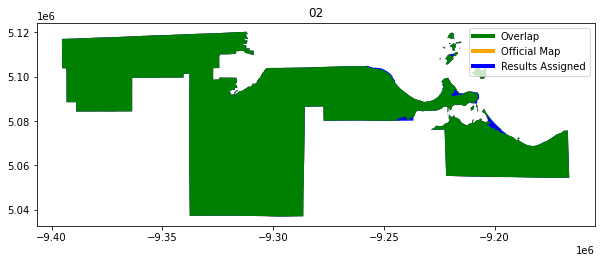

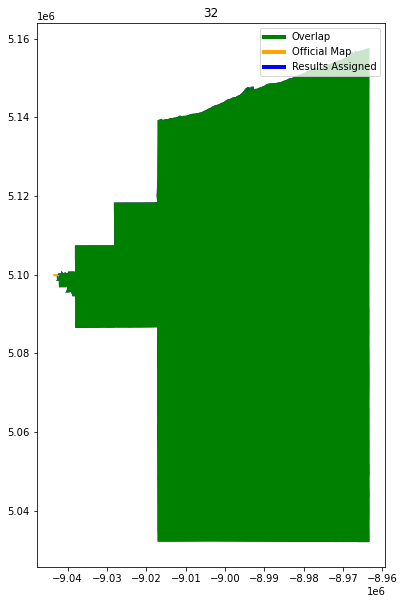

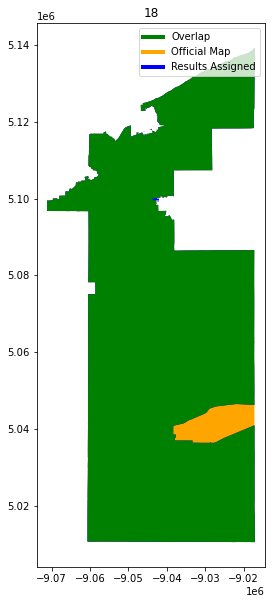

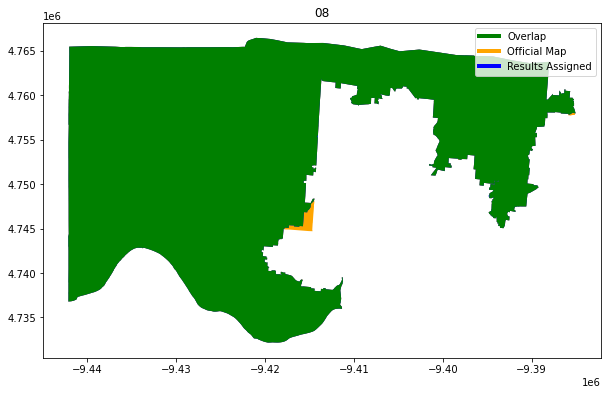

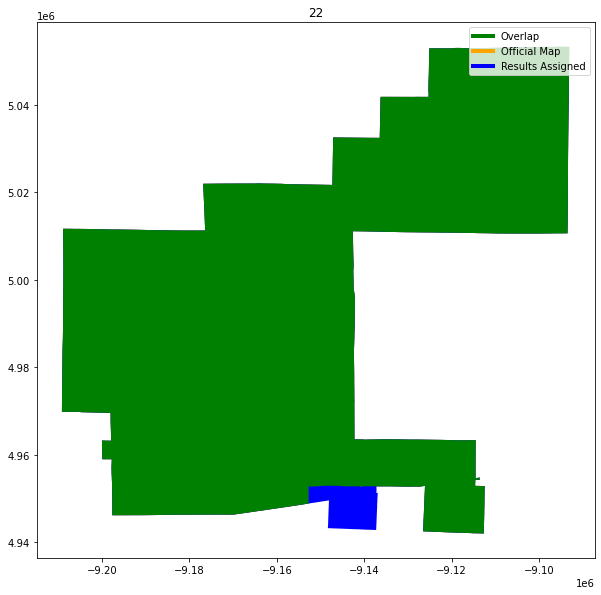

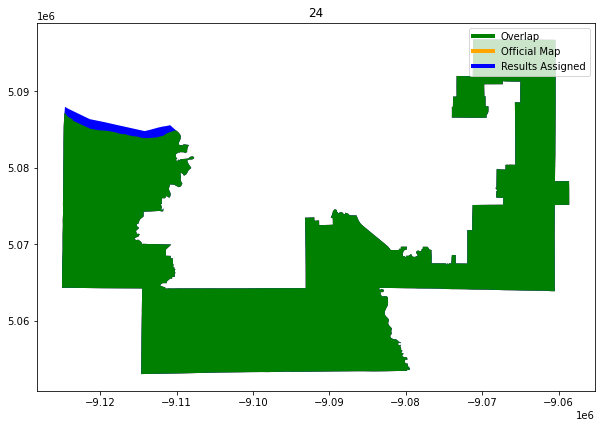

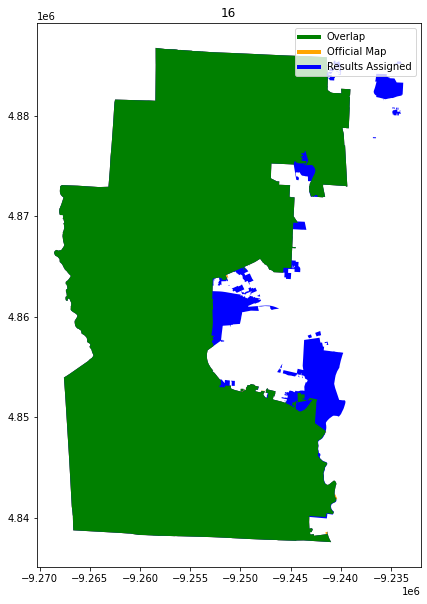

In [54]:
compare_geometries(filtered_sen,filtered_results,"Official Map","Results Assigned","SLDU_DIST",area_threshold=.1)

## Sort the columns to match what VEST has

In [55]:
attempt_one.rename(columns={'Registered Voters':'REG_VOTERS'},inplace=True)

In [56]:
attempt_one = attempt_one[['UNIQUE_ID','COUNTYFP','STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20','SLDU_DIST','GSU02RGAV', 'GSU02DODO',
       'GSU04RLAN', 'GSU04DWYE', 'GSU06RANT', 'GSU06DFOG', 'GSU08RBLE',
       'GSU08DBRO', 'GSU10DBAL', 'GSU10RHAC', 'GSU12RHUF', 'GSU12DPOL',
       'GSU14RJOH', 'GSU14DOTT', 'GSU16RKUN', 'GSU16DLET', 'GSU18RCIR',
       'GSU18DRAD', 'GSU20DJOH', 'GSU20RSCH', 'GSU22DHUN', 'GSU22RROM',
       'GSU24RDOL', 'GSU24DJAC', 'GSU26RREI', 'GSU26DSWA', 'GSU28RDOW',
       'GSU28DSYK', 'GSU30DFLE', 'GSU30RHOA', 'GSU32ROBR', 'GSU32DOBR',
       'geometry']]

## Compare population totals against what the state has

In [57]:
tot_sum = 0
for val in final_race_list:
    print(val, sum(attempt_one[val]))
    tot_sum += sum(attempt_one[val])

GSU02RGAV 122084
GSU02DODO 74240
GSU04RLAN 106021
GSU04DWYE 68000
GSU06RANT 99096
GSU06DFOG 87280
GSU08RBLE 112313
GSU08DBRO 74565
GSU10DBAL 58126
GSU10RHAC 109456
GSU12RHUF 129218
GSU12DPOL 33800
GSU14RJOH 127588
GSU14DOTT 47843
GSU16RKUN 106053
GSU16DLET 105937
GSU18RCIR 115754
GSU18DRAD 75535
GSU20DJOH 53477
GSU20RSCH 121844
GSU22DHUN 58924
GSU22RROM 130273
GSU24RDOL 112609
GSU24DJAC 94633
GSU26RREI 114776
GSU26DSWA 47050
GSU28RDOW 59701
GSU28DSYK 88929
GSU30DFLE 54694
GSU30RHOA 110243
GSU32ROBR 77404
GSU32DOBR 74367


2851833 as the total sum also matches

### Note: Checked these totals on 02/01/22 and they match what the state has here: https://www.sos.state.oh.us/elections/election-results-and-data/

In [58]:
attempt_one.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'STATEFP20', 'COUNTYFP20', 'VTDST20',
       'PRECINCT20', 'GEOID20', 'NAME20', 'SLDU_DIST', 'GSU02RGAV',
       'GSU02DODO', 'GSU04RLAN', 'GSU04DWYE', 'GSU06RANT', 'GSU06DFOG',
       'GSU08RBLE', 'GSU08DBRO', 'GSU10DBAL', 'GSU10RHAC', 'GSU12RHUF',
       'GSU12DPOL', 'GSU14RJOH', 'GSU14DOTT', 'GSU16RKUN', 'GSU16DLET',
       'GSU18RCIR', 'GSU18DRAD', 'GSU20DJOH', 'GSU20RSCH', 'GSU22DHUN',
       'GSU22RROM', 'GSU24RDOL', 'GSU24DJAC', 'GSU26RREI', 'GSU26DSWA',
       'GSU28RDOW', 'GSU28DSYK', 'GSU30DFLE', 'GSU30RHOA', 'GSU32ROBR',
       'GSU32DOBR', 'geometry'],
      dtype='object')

In [59]:
if not os.path.exists('./oh_gen_20_prec/'):
    os.mkdir('./oh_gen_20_prec/')

attempt_one.to_file('./oh_gen_20_prec/oh_gen_20_sldu_prec.shp')